In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
import re

from catboost import CatBoostRegressor
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Список мест отбора проб
locations = {
    'д. Клятле': [55.539306, 051.856451],
    'ул. Ахтубинская, 4б': [55.622944, 051.825578],
    'ул. Гагарина, 32': [55.650091, 051.852687],
    'ул. Юбилейная, 3': [55.598983, 051.771936],
    'ул. Южная, 3': [55.613193, 051.784821],
    'ул. Ямьле, 20': [55.654578, 051.800072]
}

locations_list = [
    [55.539306, 051.856451],    # д. Клятле
    [55.622944, 051.825578],    # ул. Ахтубинская, 4б
    [55.650091, 051.852687],    # ул. Гагарина, 32
    [55.598983, 051.771936],    # ул. Юбилейная, 3
    [55.613193, 051.784821],    # ул. Южная, 3
    [55.654578, 051.800072]     # ул. Ямьле, 20
    ]

In [3]:
# Функция для преобразования формата скорости ветра

def extract_value(value):
    if isinstance(value, (int, float)):
        return value
    match = re.search(r'\((\d+\.\d+)\)', str(value))
    if match:
        return float(match.group(1))
    return value

In [4]:
# Функция загрузки и подготовки данных по нужным веществам из всех 6 геоточек

def load_data(num, substance: str):
    '''num - номер геоточки
       substance - название загрязняющего вещества
    '''
    
    point = pd.read_excel(f'../data/raw/Усредненные_данные_Нижнекамск_т.{num}.xlsx')
    indexes = list(point.loc[0])
    indexes = indexes[2:]

    point = point.loc[3:].drop(columns=['Место отбора:']).set_index('Интервал отбора')
    point.columns = indexes

    point = point.apply(lambda x: x.str.replace(',', '.'))

    point['V ветра, м/с'] = point['V ветра, м/с'].apply(extract_value)
    point[['Угол ветра, °', 'Направление ветра']] = point['D ветра, °'].str.extract(r'(\d+)\s?\((.+)\)')
    point['Направление ветра'].replace(np.NaN, 'Ш', inplace=True)
        
    columns = [substance, 'V ветра, м/с', 'Угол ветра, °', 'Направление ветра']
    point = point[columns]
    
    # Заполнение пропусков, если их в концентрациях не более 5%
    for col in point.columns:
        point[col] = pd.to_numeric(point[col], errors='ignore')
    if point[substance].isna().sum().sum() / len(point) < 0.05:    ### .sum()
        point.interpolate(inplace=True)
    
    return point

In [5]:
def make_df(df, num, substance):   ### substance
    '''Функция предобработки датасета с предикторами
       num - номер геоточки
    '''

    coor = list(locations.values())[num - 1]
    target_coor = list(locations.values())[5]

    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки 6 в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km
    
    # Фичи c временными лагам
    for i in range(1, 5):
        df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
        df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
        df[f"{substance}_{i}"] = df[substance].shift(i)
    df.dropna(inplace=True)

    return df

In [6]:
def split_scale_df(X, y):
    
    # Разбиваем
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    # Масштабируем X
    scl = StandardScaler()
    scl.fit(X_train)
    X_train_scl = scl.transform(X_train)
    X_test_scl = scl.transform(X_test)

    return X_train_scl, X_test_scl, y_train, y_test

In [7]:
def plot_prediction(pred, y_test):
    
    # Отсортируем фактические значения по времени
    pred = pd.Series(pred, index=y_test.index)
    y_test_sorted = y_test.sort_index()
    pred_sorted = pred.loc[y_test_sorted.index]
    
    plt.figure(figsize=(11, 5))
    plt.plot(pred_sorted, "r", label="prediction")
    plt.plot(y_test_sorted, label="actual")
    plt.ylabel(substance)
    # plt.ylabel(y_test.name[7:]))
    plt.grid(True)
    plt.legend(loc="best")
    plt.title('Сортировка значений по времени')
    plt.show()

#### Проверим, как модель предсказывает для геоточки, на данных которой она не обучалась.  
Вещество по-прежнему одно (NO2), из метеоданных - только параметры ветра.

In [8]:
substance = 'NO2, мг/м³'

point1 = load_data(1, substance)
point2 = load_data(2, substance)
point3 = load_data(3, substance)
point4 = load_data(4, substance)
point5 = load_data(5, substance)
point6 = load_data(6, substance)

In [9]:
X1 = make_df(point1, 1, substance) #
X2 = make_df(point2, 2, substance) #
X3 = make_df(point3, 3, substance) #
X4 = make_df(point4, 4, substance) #
X5 = make_df(point5, 5, substance) #
print(X1.shape)
print(X2.shape)
print(X3.shape)
print(X4.shape)
print(X5.shape)
print()

X = pd.concat([X1, X2, X3, X4, X5], axis=0)

# Кодирование категорий
X = pd.get_dummies(X, columns=['Направление ветра'])
X.shape

(1388, 19)
(1388, 19)
(1388, 19)
(87, 19)
(597, 19)



(4848, 27)

MAE = 0.0061636739609207325


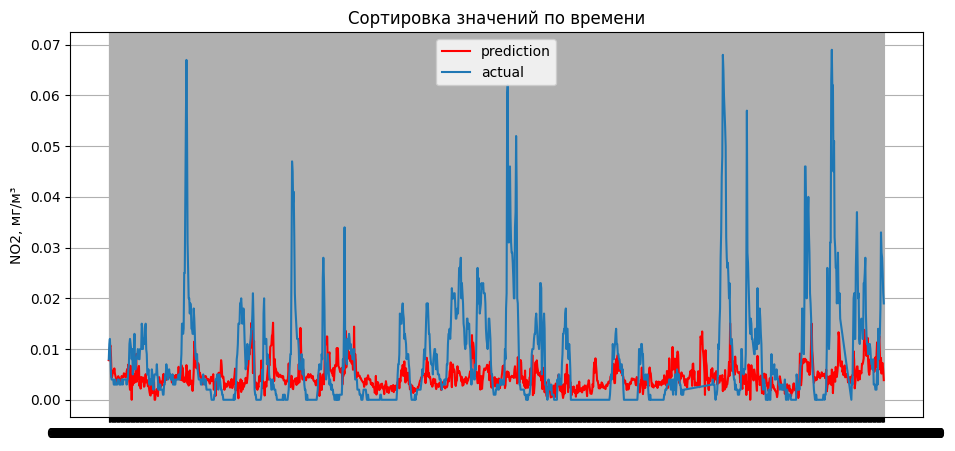


MAE = 0.004976427444348453


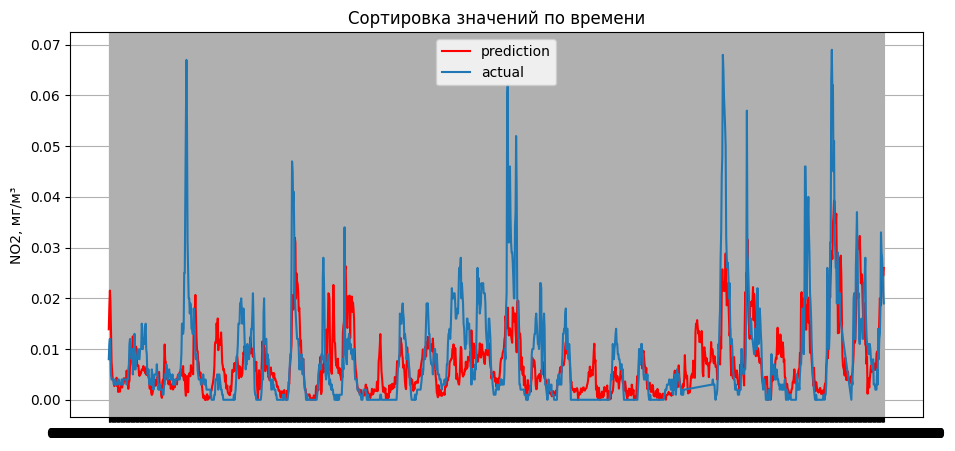


MAE = 0.00517476351228272


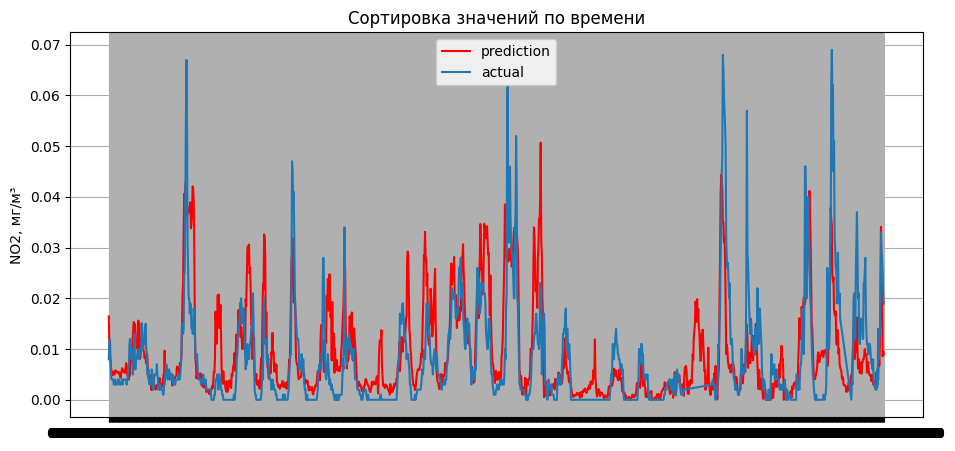


MAE = 0.011275786429535417


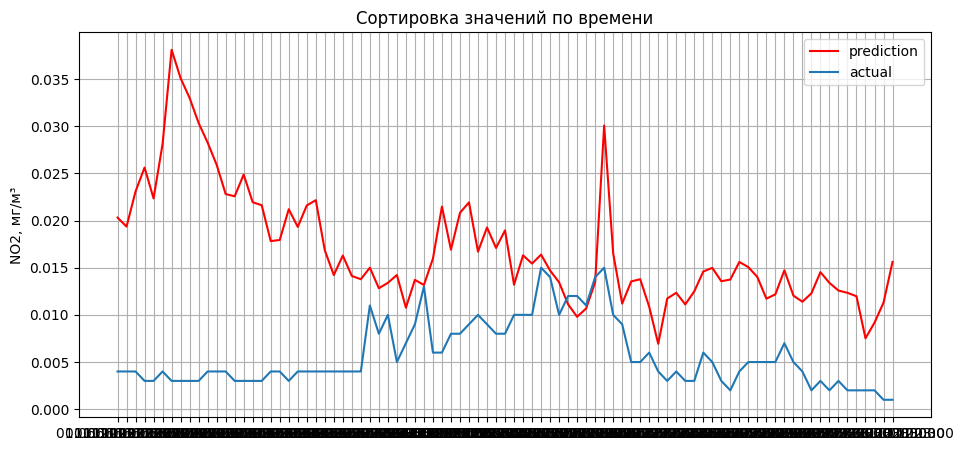


MAE = 0.004164662880609542


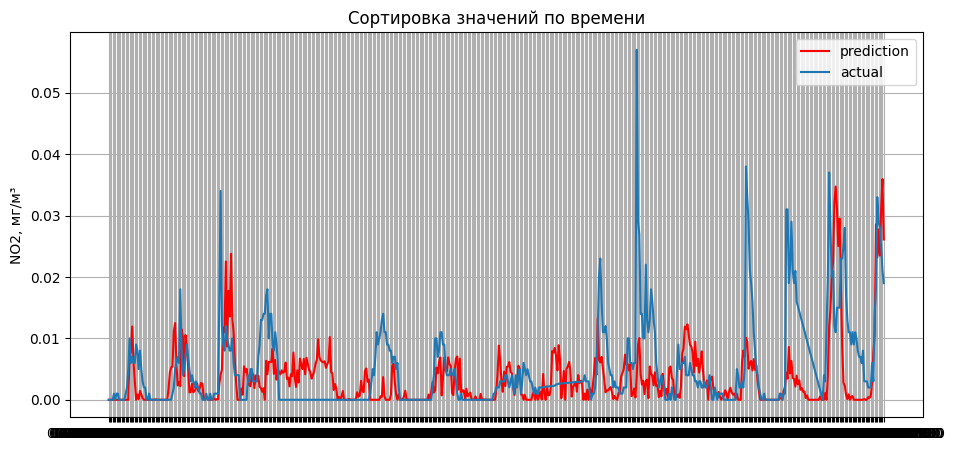

In [10]:
# Целевая переменная для y_train из геоточки 6
X['target_C, мг/м³'] = point6[substance].reindex(X.index)
X.dropna(inplace=True)

for i in range(5):
    # Для теста перебираем по очереди 5 геоточек
    test_coor = list(locations.values())[i][0]
    
    X_train = X[X['lat'] != test_coor]
    X_test = X[X['lat'] == test_coor]
    y_train = X_train.pop('target_C, мг/м³')
    y_test = X_test.pop('target_C, мг/м³')
    
    # Перемешиваем
    X_train = X_train.sample(frac=1, random_state=1)
    y_train = y_train.sample(frac=1, random_state=1)
    
    # Масштабируем
    scl = StandardScaler()
    scl.fit(X_train)
    X_train_scl = scl.transform(X_train)
    X_test_scl = scl.transform(X_test)
    
    # Обучение
    cb = CatBoostRegressor(n_estimators=300, logging_level='Silent')
    cb.fit(X_train_scl, y_train)
    
    # Оценка
    pred = cb.predict(X_test_scl)
    pred[pred < 0] = 0
    
    print('MAE =', mean_absolute_error(pred, y_test))
    plot_prediction(pred, y_test)
    print()

Худшие предсказания характерны для самого удаленного пункта (д. Клятле) и для ул. Юбилейной, откуда измерено слишком мало данных.

#### Попробуем несколько стратегий отбора веществ  
| № | Признаки (*X*) | Целевые переменные (*y*) |  
|----------|----------|----------|  
| **1**    | Одно в-во   | То же в-во   |  
| **2**    | Все в-ва   | Все в-ва   |  
| **3**    | Все в-ва   | Одно любое в-во   |  

**1.** Переберем вещества из списка в признаках и для каждого обучим свою модель. Возьмем вещества, уровень которых контролируется во всех геоточках.

In [11]:
substances = ['CO, мг/м³',
              'NO, мг/м³',
              'NO2, мг/м³', 
              'NH3, мг/м³',
            # 'NOx, мг/м³',
            # 'SO2, мг/м³',
            # 'H2S, мг/м³'
              ]

160 отрицательных значений заменены на 0
MAE = 0.1418891790164033


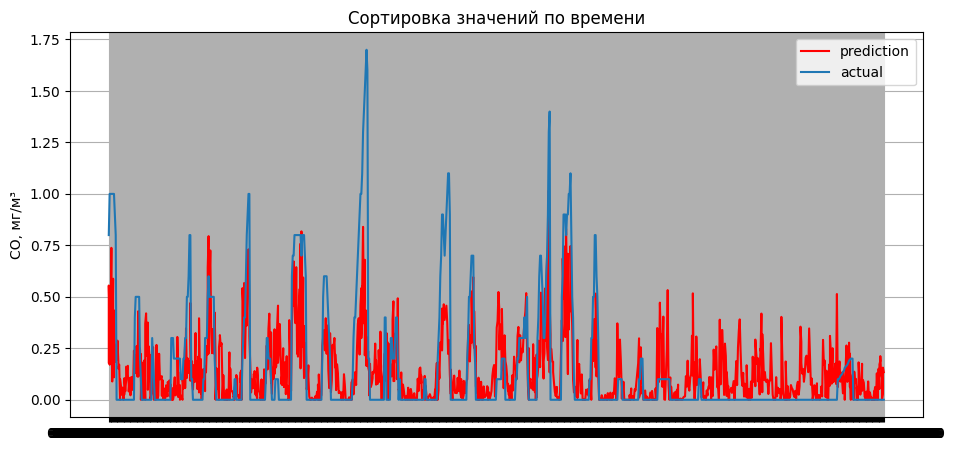


388 отрицательных значений заменены на 0
MAE = 0.0009361799678720533


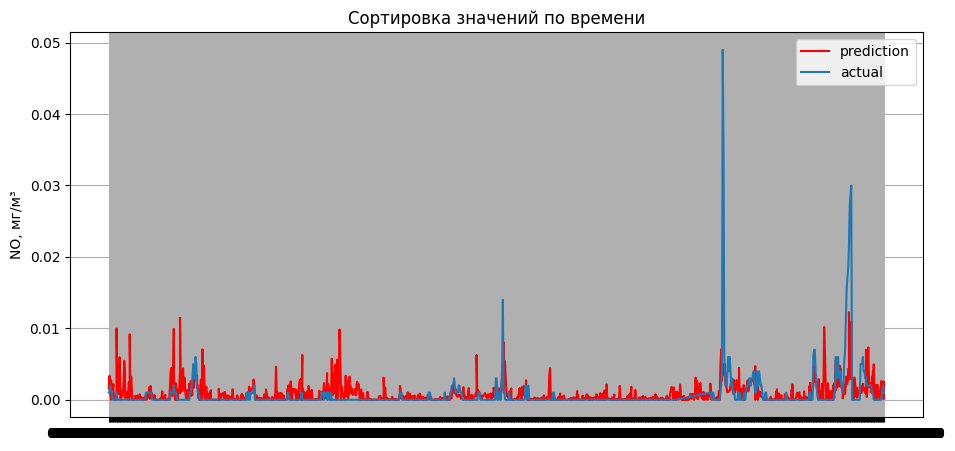


59 отрицательных значений заменены на 0
MAE = 0.003682999298128867


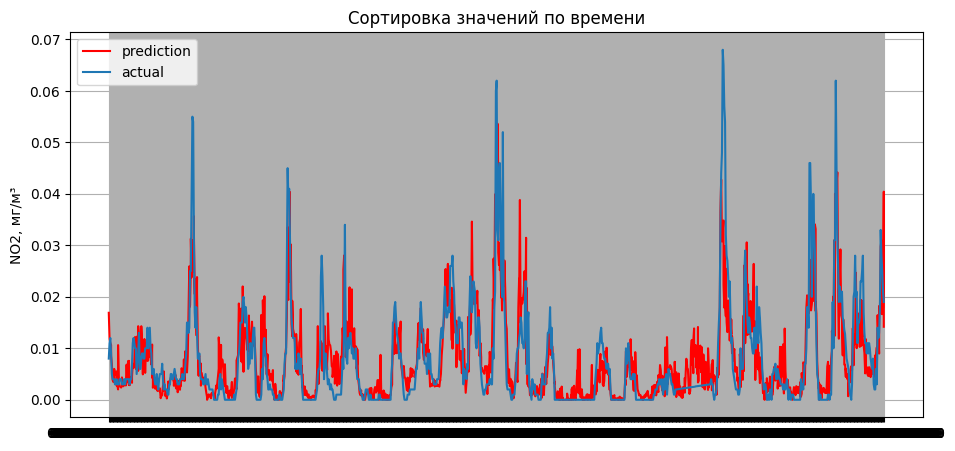


333 отрицательных значений заменены на 0
MAE = 0.0003258528374662038


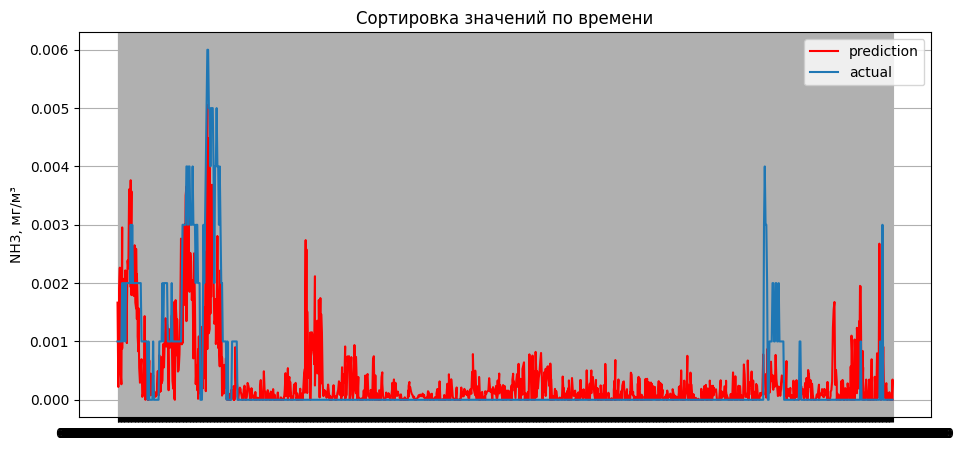

In [12]:
for substance in substances:

    point1 = load_data(1, substance)
    point2 = load_data(2, substance)
    point3 = load_data(3, substance)
    point4 = load_data(4, substance)
    point5 = load_data(5, substance)
    point6 = load_data(6, substance)
    
    X1 = make_df(point1, 1, substance) #
    X2 = make_df(point2, 2, substance) #
    X3 = make_df(point3, 3, substance) #
    X4 = make_df(point4, 4, substance) #
    X5 = make_df(point5, 5, substance) #
    X = pd.concat([X1, X2, X3, X4, X5], axis=0)
    
    # Кодирование категорий
    X = pd.get_dummies(X, columns=['Направление ветра'])
    
    # Целевая переменная
    X['target_C, мг/м³'] = point6[substance].reindex(X.index)
    X.dropna(inplace=True)
    y = X.pop('target_C, мг/м³')
    
    # Разбиваем
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    # Масштабируем
    scl = StandardScaler()
    scl.fit(X_train)
    X_train_scl = scl.transform(X_train)
    X_test_scl = scl.transform(X_test)
    
    # Обучение
    cb = CatBoostRegressor(n_estimators=300, logging_level='Silent')
    cb.fit(X_train_scl, y_train)
    
    pred = cb.predict(X_test_scl)
    
    print((pred < 0).sum(), 'отрицательных значений заменены на 0')
    pred[pred < 0] = 0
    
    print('MAE =', mean_absolute_error(pred, y_test))
    plot_prediction(pred, y_test)
    print()

**2.** Включим все вещества из списка в качестве признаков, а также добавим несколько столбцов в качестве таргета из тех же веществ. Для всего будет обучаться одна модель.

In [13]:
# Изменим функции для работы сразу со всем списком substances

In [14]:
def load_data(num, substances: list):
    '''num - номер геоточки
       substance - название загрязняющего вещества
    '''
    
    point = pd.read_excel(f'../data/raw/Усредненные_данные_Нижнекамск_т.{num}.xlsx')
    indexes = list(point.loc[0])
    indexes = indexes[2:]

    point = point.loc[3:].drop(columns=['Место отбора:']).set_index('Интервал отбора')
    point.columns = indexes

    point = point.apply(lambda x: x.str.replace(',', '.'))

    point['V ветра, м/с'] = point['V ветра, м/с'].apply(extract_value)
    point[['Угол ветра, °', 'Направление ветра']] = point['D ветра, °'].str.extract(r'(\d+)\s?\((.+)\)')
    point['Направление ветра'].replace(np.NaN, 'Ш', inplace=True)
        
    columns = [*substances, 'V ветра, м/с', 'Угол ветра, °', 'Направление ветра']  ### *
    point = point[columns]
    
    # Заполнение пропусков, если их в концентрациях не более 5%
    for col in point.columns:
        point[col] = pd.to_numeric(point[col], errors='ignore')
    if point[substances].isna().sum().sum() / len(point) < 0.05:    ### .sum()
        point.interpolate(inplace=True)
    
    return point

In [15]:
def make_df(df, num, substances: list):
    '''Функция предобработки датасета с предикторами
       num - номер геоточки
    '''

    coor = locations_list[num - 1]
    target_coor = locations_list[5]

    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки 6 в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km
    
    # Фичи c временными лагам
    for i in range(1, 5):
        df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
        df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
        for substance in substances:                           ####
            df[f"{substance}_{i}"] = df[substance].shift(i)    ####
    df.dropna(inplace=True)

    return df

In [16]:
point1 = load_data(1, substances)
point2 = load_data(2, substances)
point3 = load_data(3, substances)
point4 = load_data(4, substances)
point5 = load_data(5, substances)
point6 = load_data(6, substances)

X1 = make_df(point1, 1, substances)
X2 = make_df(point2, 2, substances)
X3 = make_df(point3, 3, substances)
X4 = make_df(point4, 4, substances)
X5 = make_df(point5, 5, substances)
X = pd.concat([X1, X2, X3, X4, X5], axis=0)

# Кодирование категорий
X = pd.get_dummies(X, columns=['Направление ветра'])

In [17]:
# 4 целевых переменных
for substance in substances:
    X[f'target_{substance}'] = point6[substance]
target_columns = [f'target_{substance}' for substance in substances]

# X = X.reindex(X.index)
X.dropna(inplace=True)

y = X[target_columns]
X = X.drop(columns=target_columns)

print(X.shape)
print(y.shape)

(3005, 42)
(3005, 4)


In [18]:
# Разбиваем
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Масштабируем
scl = StandardScaler()
scl.fit(X_train)
X_train_scl = scl.transform(X_train)
X_test_scl = scl.transform(X_test)

# Обучение
cb = CatBoostRegressor(n_estimators=300, loss_function='MultiRMSE', logging_level='Silent')
cb.fit(X_train_scl, y_train)

pred = cb.predict(X_test_scl)
print((pred < 0).sum(), 'отрицательных значений заменены на 0')
pred[pred < 0] = 0

249 отрицательных значений заменены на 0


MAE = 0.14740767085694595


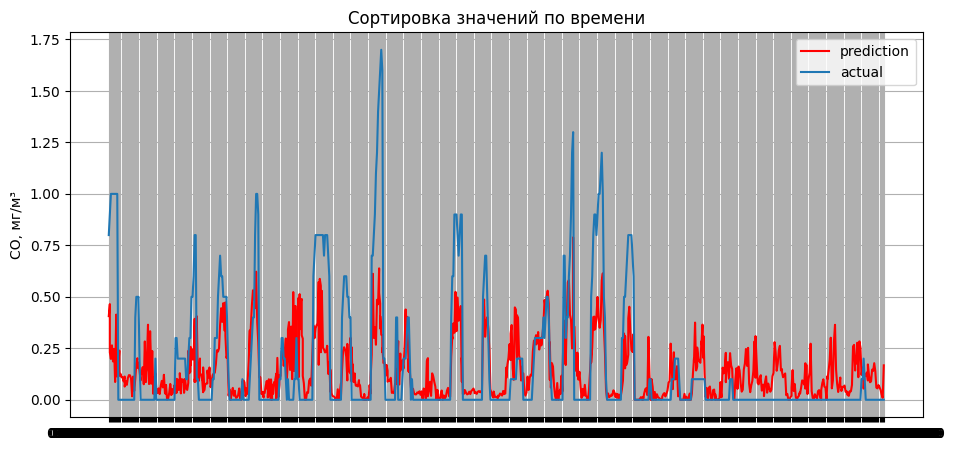


MAE = 0.0005771862268301991


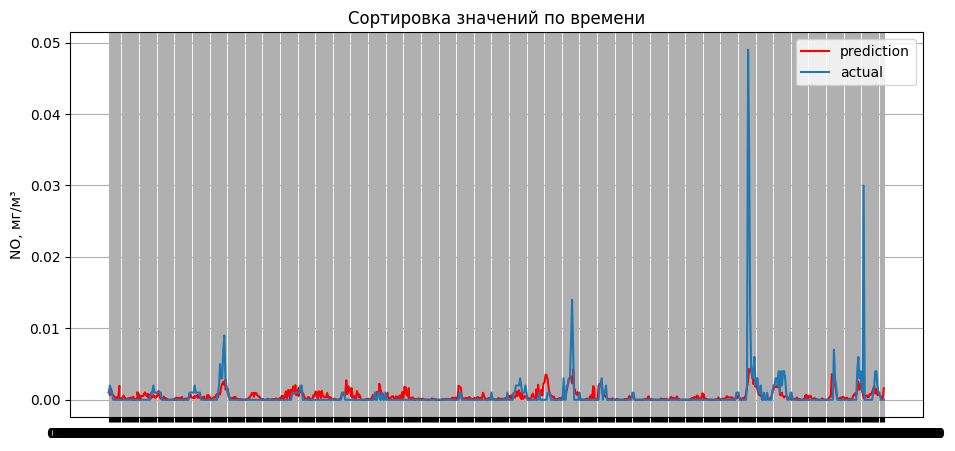


MAE = 0.0038093040301045195


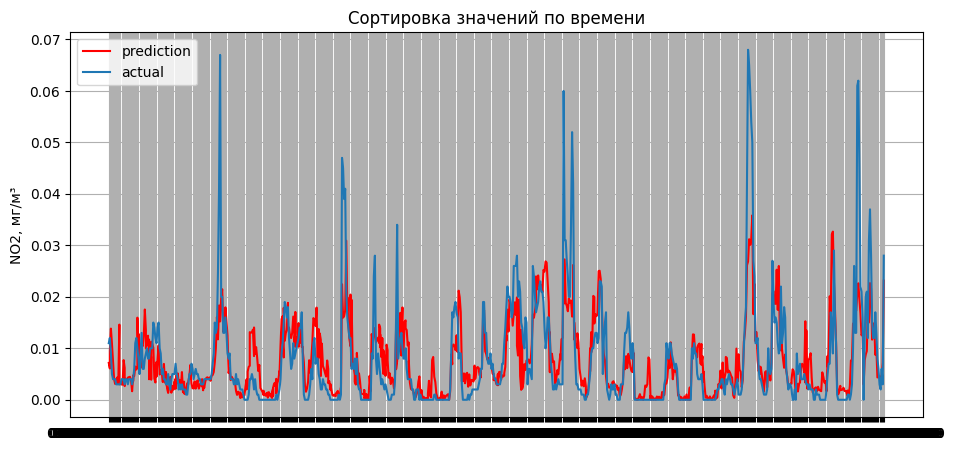


MAE = 0.00047605281621705133


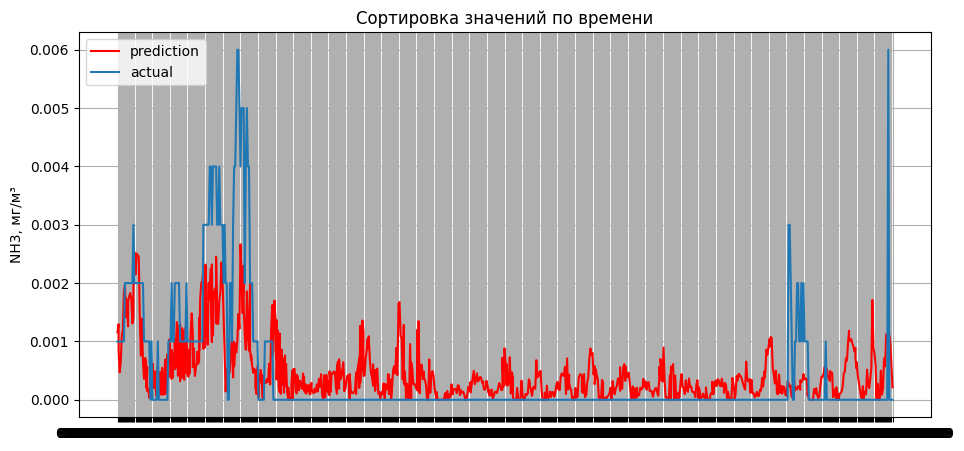

In [19]:
for i, substance in enumerate(substances):
    print('MAE =', mean_absolute_error(pred[:, i], y_test.iloc[:, i]))
    plot_prediction(pred[:, i], y_test.iloc[:, i])
    print()

**3(а).** Включим все вещества из списка в качестве признаков, но в качестве таргета возьмем одно вещество.  Для каждого целевого вещества обучим по одной модели.

In [20]:
point1 = load_data(1, substances)
point2 = load_data(2, substances)
point3 = load_data(3, substances)
point4 = load_data(4, substances)
point5 = load_data(5, substances)
point6 = load_data(6, substances)

X1 = make_df(point1, 1, substances)
X2 = make_df(point2, 2, substances)
X3 = make_df(point3, 3, substances)
X4 = make_df(point4, 4, substances)
X5 = make_df(point5, 5, substances)
X = pd.concat([X1, X2, X3, X4, X5], axis=0)

# Кодирование категорий
X = pd.get_dummies(X, columns=['Направление ветра'])

128 отрицательных значений заменены на 0
MAE = 0.12764091527133398


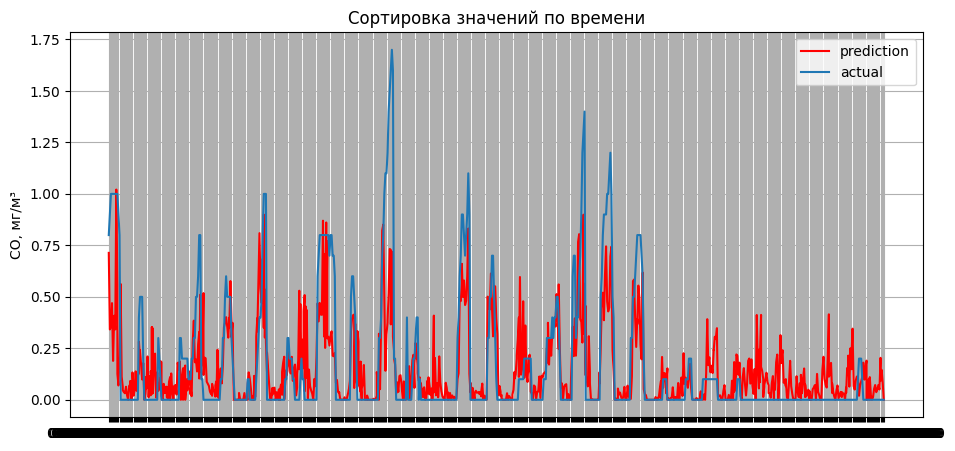


244 отрицательных значений заменены на 0
MAE = 0.0005362909377842712


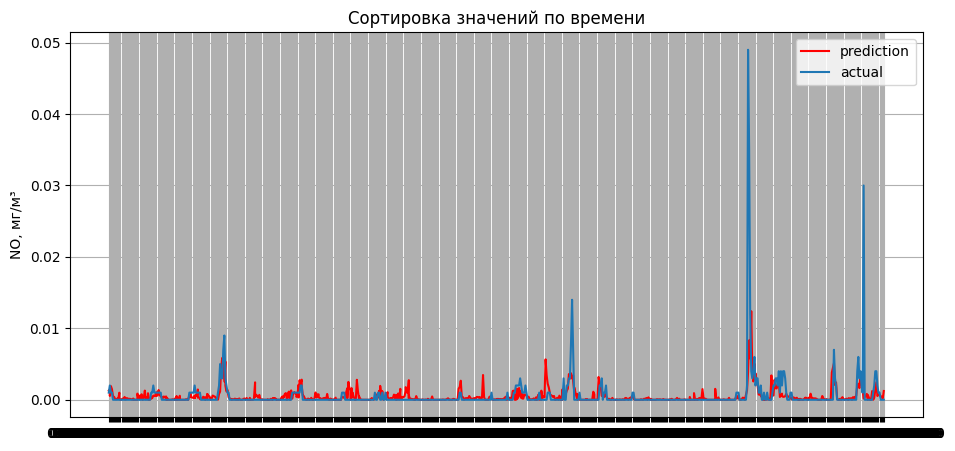


46 отрицательных значений заменены на 0
MAE = 0.0031583119485034247


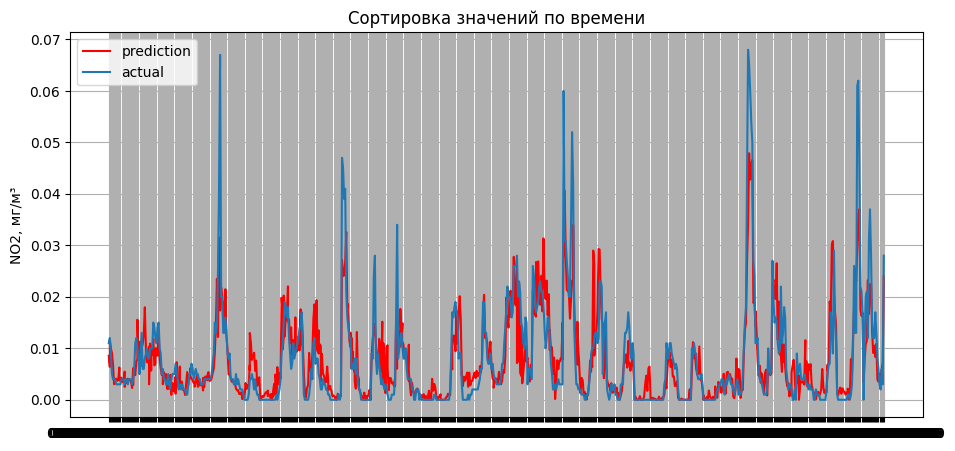


186 отрицательных значений заменены на 0
MAE = 0.0003388249538936806


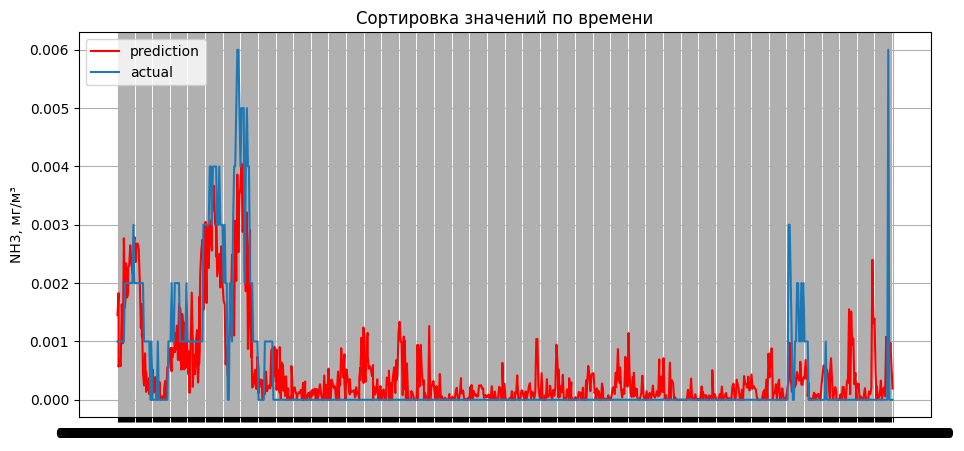

In [21]:
for substance in substances:   # меняем таргет для нового обучения

    # Целевая переменная
    X[f'target_{substance}'] = point6[substance]#.reindex(X.index)
    X.dropna(inplace=True)
    y = X.pop(f'target_{substance}')

    # Разбиваем и масштабируем
    X_train_scl, X_test_scl, y_train, y_test = split_scale_df(X, y)
    
    # Обучение
    cb = CatBoostRegressor(n_estimators=300, logging_level='Silent')
    cb.fit(X_train_scl, y_train)
    
    pred = cb.predict(X_test_scl)
    print((pred < 0).sum(), 'отрицательных значений заменены на 0')
    pred[pred < 0] = 0
    
    print('MAE =', mean_absolute_error(pred, y_test))
    plot_prediction(pred, y_test)
    print()



**3(б).** Как 3(а), но формируем признаки путем "расплавления" столбцов с веществами

In [22]:
substances = ['CO, мг/м³',
              'NO, мг/м³',
              'NO2, мг/м³', 
              'NH3, мг/м³',
            # 'NOx, мг/м³',
              'SO2, мг/м³',   ##
              'H2S, мг/м³'    ##
              ]
# Молекулярные массы веществ из substances
Mr = [28, 30, 46, 17, 64, 34]

In [23]:
# Опять меняем функию, чтобы загружать данные по всем веществам, а не по заданным веществам

In [24]:
def load_data(num, all_substances):    # substances
    '''num - номер геоточки
       substance - название загрязняющего вещества
    '''
    
    point = pd.read_excel(f'../data/raw/Усредненные_данные_Нижнекамск_т.{num}.xlsx')
    indexes = list(point.loc[0])
    indexes = indexes[2:]

    point = point.loc[3:].drop(columns=['Место отбора:']).set_index('Интервал отбора')
    point.columns = indexes

    point = point.apply(lambda x: x.str.replace(',', '.'))

    point['V ветра, м/с'] = point['V ветра, м/с'].apply(extract_value)
    point[['Угол ветра, °', 'Направление ветра']] = point['D ветра, °'].str.extract(r'(\d+)\s?\((.+)\)')
    point['Направление ветра'].replace(np.NaN, 'Ш', inplace=True)
        
    # Пересечение множеств названий столбцов и substances
    substances = set(indexes) & set(all_substances)
    columns = [*substances, 'V ветра, м/с', 'Угол ветра, °', 'Направление ветра']
    point = point[columns]

    # Заполнение пропусков, если их в концентрациях не более 5%
    for col in point.columns:
        point[col] = pd.to_numeric(point[col], errors='ignore')
    if point[list(substances)].isna().sum().sum() / len(point) < 0.05:   ## list()
        point.interpolate(inplace=True)
    
    return point

def make_df(df, num):   ### substance
    '''Функция предобработки датасета с предикторами
       num - номер геоточки
    '''

    coor = locations_list[num - 1]
    target_coor = locations_list[5]

    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки 6 в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km
    
    # Фичи c временными лагам
    for i in range(1, 5):
        df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
        df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
        df[f"C, мг/м³_{i}"] = df['C, мг/м³'].shift(i)   ## 'C, мг/м³'
    df.dropna(inplace=True)

    return df

In [25]:
point1 = load_data(1, substances)
point2 = load_data(2, substances)
point3 = load_data(3, substances)
point4 = load_data(4, substances)
point5 = load_data(5, substances)
point6 = load_data(6, substances)

In [26]:
def melt_columns(df, substances, Mr):
    
    df = pd.melt(df, id_vars=['V ветра, м/с', 'Угол ветра, °', 'Направление ветра'],
                value_vars=list(df.iloc[:, :-3]), ignore_index=False)

    # Закодируем названия веществ их молекулярной массой
    df.replace(substances, Mr, inplace=True)
    df.rename(columns={"variable": "Mr", "value": "C, мг/м³"}, inplace=True)

    df["Mr"] = pd.to_numeric(df["Mr"], errors='coerce')

    return df

In [27]:
point1 = melt_columns(point1, substances, Mr)
point2 = melt_columns(point2, substances, Mr)
point3 = melt_columns(point3, substances, Mr)
point4 = melt_columns(point4, substances, Mr)
point5 = melt_columns(point5, substances, Mr)

In [28]:
X1 = make_df(point1, 1)
X2 = make_df(point2, 2)
X3 = make_df(point3, 3)
X4 = make_df(point4, 4)
X5 = make_df(point5, 5)

In [29]:
X = pd.concat([X1, X2, X3, X4, X5], axis=0)

# Кодирование категорий
X = pd.get_dummies(X, columns=['Направление ветра'])
X.shape

(27174, 28)

In [30]:
# Сколько записей со штилем
# len(X[X["Направление ветра"] == 'Ш'])

1182 отрицательных значений заменены на 0
MAE = 0.08994132054410568


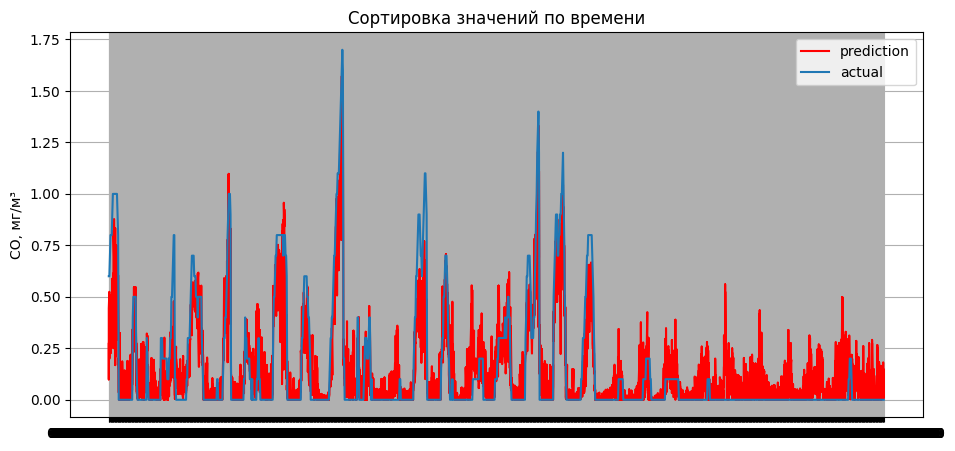


2036 отрицательных значений заменены на 0
MAE = 0.00033549737730808216


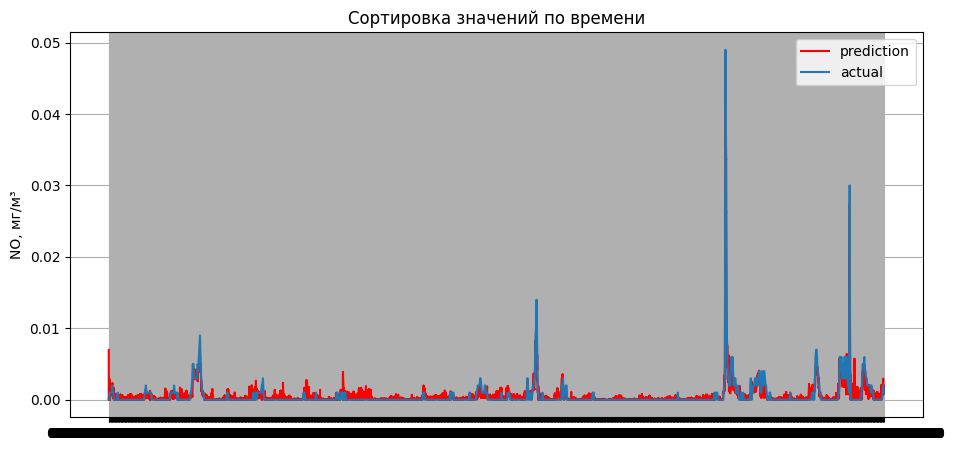


310 отрицательных значений заменены на 0
MAE = 0.0023885571338231534


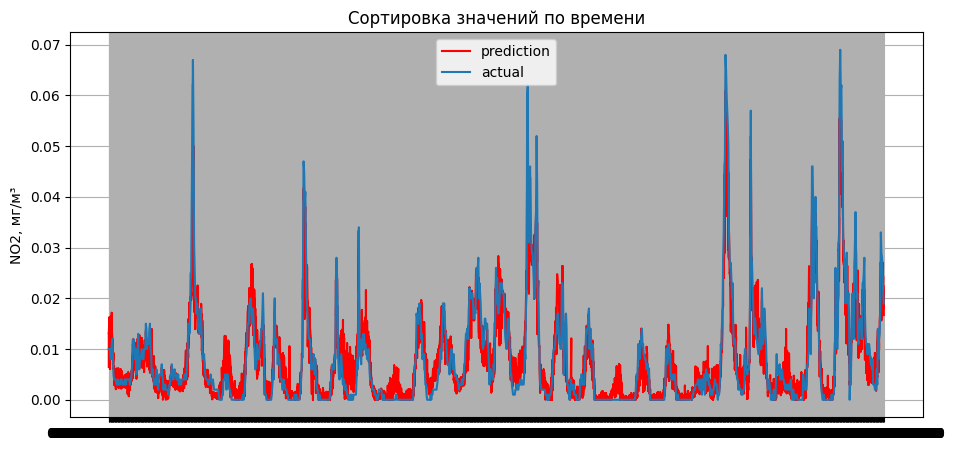


1555 отрицательных значений заменены на 0
MAE = 0.00023961143761295917


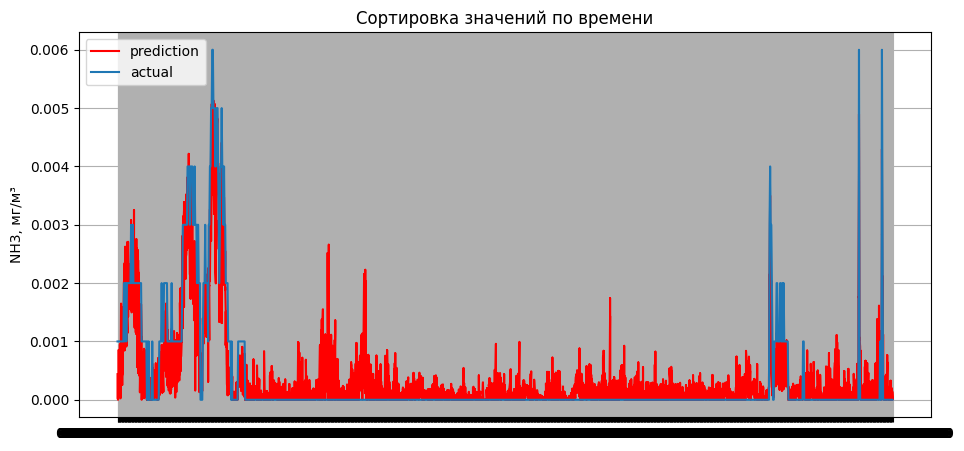


435 отрицательных значений заменены на 0
MAE = 0.0018662584384320747


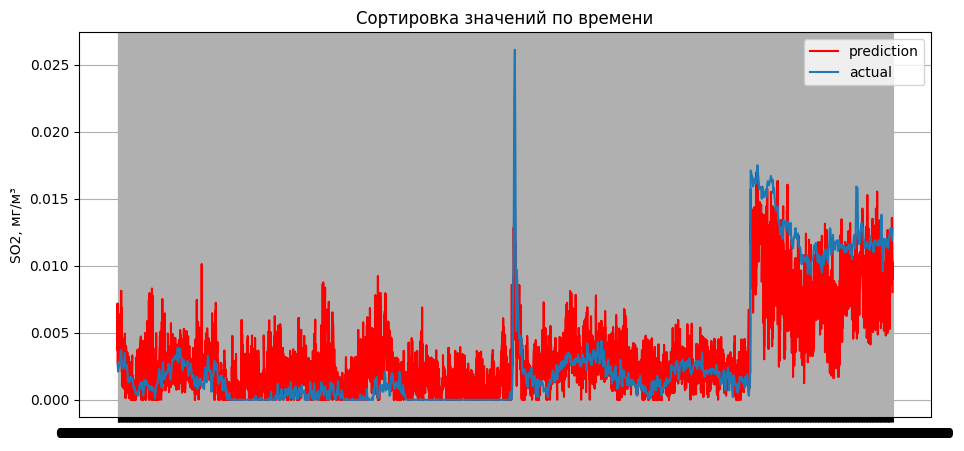


113 отрицательных значений заменены на 0
MAE = 0.0009191889884676656


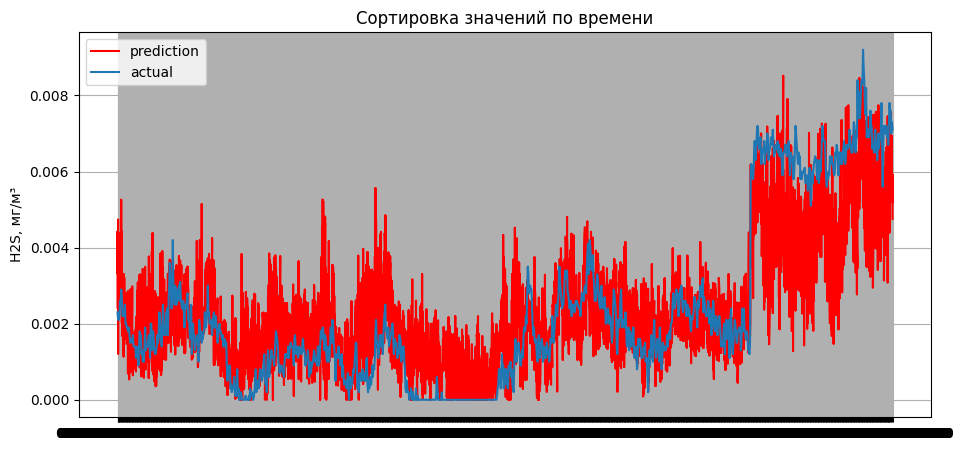

In [31]:
for substance in substances:   # меняем таргет для нового обучения

    # Целевая переменная
    X[f'target_{substance}'] = point6[substance]#.reindex(X.index)
    X.dropna(inplace=True)
    X.drop_duplicates(inplace=True)
    y = X.pop(f'target_{substance}')

    # Разбиваем и масштабируем
    X_train_scl, X_test_scl, y_train, y_test = split_scale_df(X, y)
    
    # Обучение
    cb = CatBoostRegressor(n_estimators=300, logging_level='Silent')
    cb.fit(X_train_scl, y_train)
    
    pred = cb.predict(X_test_scl)
    print((pred < 0).sum(), 'отрицательных значений заменены на 0')
    pred[pred < 0] = 0
    
    print('MAE =', mean_absolute_error(pred, y_test))
    plot_prediction(pred, y_test)
    print()

Пока последняя стратегия (3*б*) формирования признаков - лучшая